In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import keras.backend as K
from keras.callbacks import LambdaCallback, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam, RMSprop

from PIL import Image
from nltk.translate import bleu_score

# Import Custom Module
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)


Using TensorFlow backend.


In [2]:
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

***

In [3]:
from src.utils.config import IMAGES_DIR
from src.utils.sets import (
    init_image_descriptions_map,
    load_set_images,
    init_image_descriptions_map_set,
    data_generator
)

from src.utils.image import load_image, load_image_embedding_map
from src.utils.sequence import clean, init_idx_word_map, init_word_idx_map

from src.nn import NeuralImageCaptioning, NICInference

***

## Understanding and formating the data

In [4]:
image2descriptions = init_image_descriptions_map()

image2descriptions['101654506_8eb26cfb60']

['A brown and white dog is running through the snow .',
 'A dog is running in the snow',
 'A dog running through snow .',
 'a white and brown dog is running through a snow covered field .',
 'The white and brown dog is running over the surface of the snow .']

***

## Data Cleaning

In [5]:
clean(
    'A HellO! How12 are yoU>??'
)

'a hello are you'

In [6]:
for img_name, descriptions in image2descriptions.items():
    image2descriptions[img_name] = [clean(descr) for descr in descriptions]

In [7]:
image2descriptions['101654506_8eb26cfb60']

['a brown and white dog is running through the snow',
 'a dog is running in the snow',
 'a dog running through snow',
 'a white and brown dog is running through a snow covered field',
 'the white and brown dog is running over the surface of the snow']

***

## Create a Vocabulary

In [8]:
vocabulary = set()

for key in image2descriptions.keys():
    [vocabulary.update(descr.split()) for descr in image2descriptions[key]]

In [9]:
vocabulary.update('0')
vocabulary.update(['<START>'])
vocabulary.update(['<END>'])

In [10]:
print('Vocabulary size: {}'.format(len(vocabulary)))

Vocabulary size: 8767


### Sort the Vocabulary lexically

In [11]:
vocabulary = sorted(vocabulary)

## Word2Idx and Idx2Word maps

In [12]:
word2idx = init_word_idx_map(vocabulary)
idx2word = init_idx_word_map(vocabulary)

In [13]:
word2idx['dog']

2224

In [14]:
idx2word[2224]

'dog'

***

## Max Description Length

In [15]:
descriptions = []

for key, val in image2descriptions.items():
    for descr in val:
        descriptions.append(descr)

print('Total number of descriptions: {}'.format(len(descriptions)))

Total number of descriptions: 40460


In [16]:
longets_description = max(descriptions, key=lambda x: len(x.split()))

print('Longes description:\n\n"{}"'.format(longets_description))

Longes description:

"an africanamerican man wearing a green sweatshirt and blue vest is holding up dollar bills in front of his face while standing on a busy sidewalk in front of a group of men playing instruments"


In [17]:
max_description_length = len(longets_description.split()) + 2

print('Max Description Length: {}'.format(max_description_length))

Max Description Length: 37


***

## Train/Dev/Test split

In [18]:
train_images = load_set_images('train')
dev_images = load_set_images('dev')
test_images = load_set_images('test')

print('Train size: {}'.format(len(train_images)))
print('Dev size: {}'.format(len(dev_images)))
print('Test size: {}'.format(len(test_images)))

Train size: 6000
Dev size: 1000
Test size: 1000


### Init Image->Descriptions Maps Sets

In [19]:
train_image2descriptions = init_image_descriptions_map_set(train_images, image2descriptions)
dev_image2descriptions = init_image_descriptions_map_set(dev_images, image2descriptions)
test_image2descriptions = init_image_descriptions_map_set(test_images, image2descriptions)

print('Train size: {}'.format(len(train_image2descriptions)))
print('Dev size: {}'.format(len(dev_image2descriptions)))
print('Test size: {}'.format(len(test_image2descriptions)))

Train size: 6000
Dev size: 1000
Test size: 1000


In [20]:
train_image2descriptions['2513260012_03d33305cf']

['a black dog is running after a white dog in the snow',
 'black dog chasing brown dog through snow',
 'two dogs chase each other across the snowy ground',
 'two dogs play together in the snow',
 'two dogs running through a low lying body of water']

***

## Merge Train and Dev, hold-out set: Test

In [21]:
train_image2descriptions = {**train_image2descriptions, **dev_image2descriptions}

In [22]:
print('Train size: {}'.format(len(train_image2descriptions)))
print('Test size: {}'.format(len(test_image2descriptions)))

Train size: 7000
Test size: 1000


***

## Creating Image-Embedding Maps

In [23]:
train_image2embedding = load_image_embedding_map('train', train_image2descriptions)
test_image2embedding = load_image_embedding_map('test', test_image2descriptions)

"train" Image-Embedding Map loaded.
"test" Image-Embedding Map loaded.


***

In [24]:
EMBEDDING_DIM = 300
NUM_HIDDEN_NEURONS = [256, 256]

***

# Model

![NIC_model](../../img/NIC.png)

In [25]:
neural_image_captioning = NeuralImageCaptioning(
    EMBEDDING_DIM, max_description_length, len(vocabulary), NUM_HIDDEN_NEURONS, word2idx)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [26]:
print(neural_image_captioning.model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_embedding_input (InputLay (None, 2048)         0                                            
__________________________________________________________________________________________________
sequence_input (InputLayer)     (None, 37)           0                                            
__________________________________________________________________________________________________
top_image_encoder (Model)       (None, 1, 300)       2405676     image_embedding_input[0][0]      
__________________________________________________________________________________________________
sequence_decoder (Model)        (None, 37, 8767)     5978899     sequence_input[0][0]             
                                                                 top_image_encoder[1][0]          
Total para

***

## Run

### Callbacks

In [27]:
filepath = '../weights/nic-weights.hdf5'
checkpoint = ModelCheckpoint(filepath, verbose=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss')


callbacks = [checkpoint, reduce_lr]

### Load / Compile

In [28]:
neural_image_captioning.model.load_weights('../weights/nic-weights.hdf5')

neural_image_captioning.model.compile(Adam(1e-5), loss='categorical_crossentropy')

### Prepare

In [29]:
num_epochs = 1000
batch_size = 128
steps = (len(train_image2descriptions) * 5) // batch_size
val_batch_size = 16
val_steps = (len(test_image2descriptions) * 5) // val_batch_size


train_data_generator = data_generator(
    train_image2descriptions,
    train_image2embedding,
    word2idx,
    batch_size,
    max_description_length,
    len(vocabulary),
)

val_data_generator = data_generator(
    test_image2descriptions,
    test_image2embedding,
    word2idx,
    val_batch_size,
    max_description_length,
    len(vocabulary),
)

### Train

In [70]:
neural_image_captioning.model.fit_generator(
    generator=train_data_generator,
    steps_per_epoch=steps,
    epochs=num_epochs,
    verbose=True,
    callbacks=callbacks,
    validation_data=val_data_generator,
    validation_steps=val_steps,
)

Epoch 1/1000
546/546 [==============================] - 174s 319ms/step - loss: 1.2703 - val_loss: 3.4541

Epoch 00001: saving model to ../weights/nic-weights.hdf5
Epoch 2/1000
546/546 [==============================] - 157s 287ms/step - loss: 1.2682 - val_loss: 3.4525

Epoch 00002: saving model to ../weights/nic-weights.hdf5
Epoch 3/1000
546/546 [==============================] - 157s 287ms/step - loss: 1.2671 - val_loss: 3.4509

Epoch 00003: saving model to ../weights/nic-weights.hdf5
Epoch 4/1000
546/546 [==============================] - 157s 288ms/step - loss: 1.2689 - val_loss: 3.4560

Epoch 00004: saving model to ../weights/nic-weights.hdf5
Epoch 5/1000
546/546 [==============================] - 155s 284ms/step - loss: 1.2693 - val_loss: 3.4486

Epoch 00005: saving model to ../weights/nic-weights.hdf5
Epoch 6/1000
546/546 [==============================] - 156s 286ms/step - loss: 1.2685 - val_loss: 3.4514

Epoch 00006: saving model to ../weights/nic-weights.hdf5
Epoch 7/1000
546

KeyboardInterrupt: 

***

## Test

In [59]:
inference = NICInference(neural_image_captioning, word2idx)

In [60]:
def show_img(path_to_img):
    img = Image.open(path_to_img)
    img.load()
    plt.imshow(np.asarray(img, dtype='int32'));

def evaluate(img_id, beam_width=3):
    print('Image ID: {}'.format(img_id))
    print('='*50)
    print()
    img = load_image(img_id)
    
    greedy_hypothesis = inference.greedy_search(img)
    beam_hypothesis = inference.beam_search(img, beam_width=beam_width)
    references = image2descriptions[img_id]

    print('Greedy Search: {}'.format(greedy_hypothesis))
    print('Beam Search: {}'.format(beam_hypothesis))
    print()
    
    print('BLEU score Greedy Search: {}'.format(bleu_score.sentence_bleu(references, greedy_hypothesis)))
    print('BLEU score Beam Search: {}'.format(bleu_score.sentence_bleu(references, beam_hypothesis)))
    print()
    
    print('Greedy Search Hypothesis Log Probabilty: {}'.format(inference.predict_logprob(img, greedy_hypothesis)))
    print('Beam Search Hypothesis Log Probabilty: {}'.format(inference.predict_logprob(img, beam_hypothesis)))
    
    show_img(IMAGES_DIR+img_id+'.jpg')

Image ID: 224273695_0b517bd0eb

Greedy Search: a snowy peak
Beam Search: a group of mountains

BLEU score Greedy Search: 1.0
BLEU score Beam Search: 0.7122199614597924

Greedy Search Hypothesis Log Probabilty: -17.236722946166992
Beam Search Hypothesis Log Probabilty: -31.933027267456055


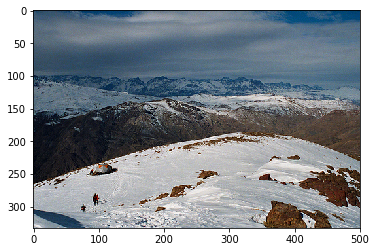

In [61]:

evaluate(
    np.random.choice(list(test_image2descriptions.keys())), beam_width=10
)

Image ID: 255091927_2eb643beb2

Greedy Search: three people recline in massage chairs
Beam Search: three people recline in massage chairs

BLEU score Greedy Search: 1.0
BLEU score Beam Search: 1.0

Greedy Search Hypothesis Log Probabilty: -47.24000549316406
Beam Search Hypothesis Log Probabilty: -47.24000549316406


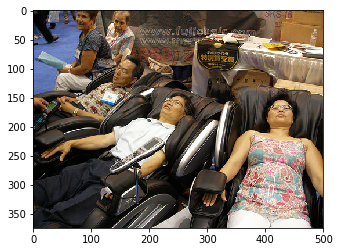

In [62]:
evaluate(
    np.random.choice(list(test_image2descriptions.keys())), beam_width=10
)

Image ID: 957682378_46c3b07bcd

Greedy Search: a black dog and a brown dog are playing with a soccer ball
Beam Search: a black dog and a brown dog run in the dirt

BLEU score Greedy Search: 0.8107023264227885
BLEU score Beam Search: 0.8105311186244134

Greedy Search Hypothesis Log Probabilty: -122.53227233886719
Beam Search Hypothesis Log Probabilty: -104.20531463623047


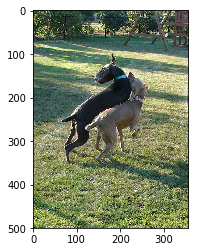

In [63]:
evaluate(
    np.random.choice(list(test_image2descriptions.keys())), beam_width=50
)

Image ID: 2136514643_93d8f75a77

Greedy Search: a girl in a pink dress walks with her arms crossed
Beam Search: a girl in white haired girl

BLEU score Greedy Search: 0.6078993485184253
BLEU score Beam Search: 0.31359024781900885

Greedy Search Hypothesis Log Probabilty: -97.00406646728516
Beam Search Hypothesis Log Probabilty: -48.83020782470703


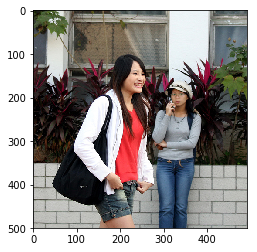

In [64]:
evaluate(
    np.random.choice(list(test_image2descriptions.keys())), beam_width=50
)

Image ID: 412203580_2c7278909c

Greedy Search: a young boy in a yellow wetsuit is falling in the water
Beam Search: a boy is riding a wakeboarding

BLEU score Greedy Search: 0.5628328782110598
BLEU score Beam Search: 0.5097191148920521

Greedy Search Hypothesis Log Probabilty: -107.9584732055664
Beam Search Hypothesis Log Probabilty: -54.67326354980469


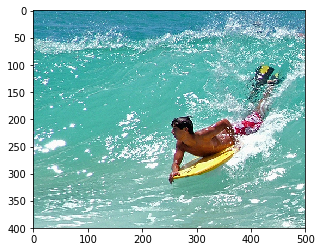

In [65]:
evaluate(
    np.random.choice(list(test_image2descriptions.keys())), beam_width=100
)

Image ID: 3138504165_c7ae396294

Greedy Search: a hockey player in a red and white uniform guarding the goal
Beam Search: a hockey player hockey players with the game

BLEU score Greedy Search: 0.6985881652813911
BLEU score Beam Search: 0.5869890721118388

Greedy Search Hypothesis Log Probabilty: -114.3213882446289
Beam Search Hypothesis Log Probabilty: -68.64219665527344


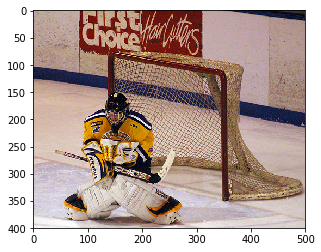

In [66]:
evaluate(
    np.random.choice(list(test_image2descriptions.keys())), beam_width=100
)